# PyMC dims module

## A short history of dims in PyMC

PyMC introduced the ability to specify model variable `dims` in version 3.9 in June 2020 (5 years as of the time of writing). There was a discrete mention following [14 other new features](https://github.com/pymc-devs/pymc/blob/1d00f3eb81723523968f3610e81a0c42fd96326f/RELEASE-NOTES.md?plain=1#L236), for a feature that would over time become a foundation of the library.

It allows users to more naturally specify the dimensions of model variables with strings and provides a "seamless" conversion to arviz :doc:`InferenceData <arviz:xarray_for_arviz>` objects, which have become the standard for storing and investigating results from probabilistic programming languages.

However, the behavior of dims is rather limited. It can only be used to specify the shape of new random variables and label existing dimensions (e.g., in :func:`~pymc.Deterministic`). It has otherwise no effect on the computation, unlike operations done with :class:`~arviz.InferenceData` variables, which are based on :mod:`xarray` and where dims inform array selection, alignment and broadcasting behavior.

In contrast, with PyMC models, users have to write computations that follow numpy semantics, which usually mean a plethora of transpositions, reshapes, new axis (`None`) and numerical axis arguments sprinkled everywhere. It can be hard to get these right and after all is said and done, it's somewhat hard to make sense of the written model.

## Expanding the role of dims

PyMC introduces an experimental :mod:`pymc.dims` module that allows users to define data, distributions and math operations that respect dim semantics, as close as possible to xarray. Let us take a look. We start with a model written in old-fashioned PyMC syntax:

In [1]:
import numpy as np

import pymc as pm

seed = sum(map(ord, "dims module"))
rng = np.random.default_rng(seed)

In [2]:
# Very realistic looking data!
observed_response_np = np.ones((5, 20), dtype=int)
coords = coords = {
    "participant": range(5),
    "trial": range(20),
    "item": range(3),
}
with pm.Model(coords=coords) as model:
    observed_response = pm.Data(
        "observed_response", observed_response_np, dims=("participant", "trial")
    )
    # Use ZeroSumNormal to avoid identifiability issues
    participant_preference = pm.ZeroSumNormal(
        "participant_preference", n_zerosum_axes=1, dims=("participant", "item")
    )

    # Shared time effects across all participants
    time_effects = pm.Normal("time_effects", dims=("trial", "item"))

    trial_preference = pm.Deterministic(
        "trial_preference",
        participant_preference[:, None, :] + time_effects[None, :, :],
        dims=("participant", "trial", "item"),
    )

    response = pm.Categorical(
        "response",
        p=pm.math.softmax(trial_preference, axis=-1),
        observed=observed_response,
        dims=("participant", "trial"),
    )

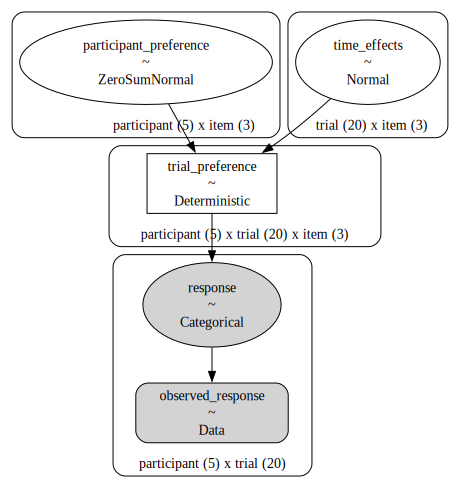

In [3]:
model.to_graphviz()

And now let's write the equivalent model using the :mod:`pymc.dims` module.

In [4]:
import pymc.dims as pmd

/home/ricardo/Documents/pymc/pymc/dims/__init__.py:66: UserWarning: The `pymc.dims` module is experimental and may contain critical bugs (p=0.565).
Please report any issues you encounter at https://github.com/pymc-devs/pymc/issues.
Disclaimer: This an experimental API and may change at any time.
  __init__()


In [5]:
with pm.Model(coords=coords) as dmodel:
    observed_response = pmd.Data(
        "observed_response", observed_response_np, dims=("participant", "trial")
    )
    participant_preference = pmd.ZeroSumNormal(
        "participant_preference", core_dims="item", dims=("participant", "item")
    )

    # Shared time effects across all participants
    time_effects = pmd.Normal("time_effects", dims=("item", "trial"))

    trial_preference = pmd.Deterministic(
        "trial_preference",
        participant_preference + time_effects,
    )

    response = pmd.Categorical(
        "response",
        p=pmd.math.softmax(trial_preference, dim="item"),
        core_dims="item",
        observed=observed_response,
    )

Note we still use the same :class:`~pymc.Model` constructor, but everything else was now defined with an equivalent function or class defined in the :mod:`pymc.dims` module.

There are some notable differences:
1. ZeroSumNormal takes a `core_dims` argument instead of `n_zerosum_axes`. This tells PyMC, which of the `dims` that define the distribution are constrained to be zero-summed. All distributions that take non-scalar parameters now require a `core_dims` argument, whereas before they were assumed to be right-aligned by the user (see more in :doc:`dimensionality`). This is no longer necessary. You shouldn't have to worry about the order of the dimensions in your model, just their meaning!
2. The `trial_preference` computation is mathematically equivalent to what we had before, without us having to align dimensions for broadcasting following numpy-semantics.
3. The `softmax` operation is defined based on the `dim` argument, not the positional axis. Note: Why is it `dim` and not `core_dims`? We try to stay as close as possible to xarray syntax which use `dim` throughout (even though they don't have a softmax operation). The xarray functions use `dim` so we use it as well. However, reusing `dim` for distributions would probably be confusing, since they already have the `dims` argument.
4. The `Categorical` observed variable, like `ZeroSumNormal` requires a `core_dims` argument, to know which dimension corresponds to the probability vector. Before users were requested to place this dimension explicitly on the rightmost axis. This is not necessary anymore.
5. Even though dims were not specified for either `trial_preference` or `response`, PyMC automatically infers them. You can check the graphviz representation is identical

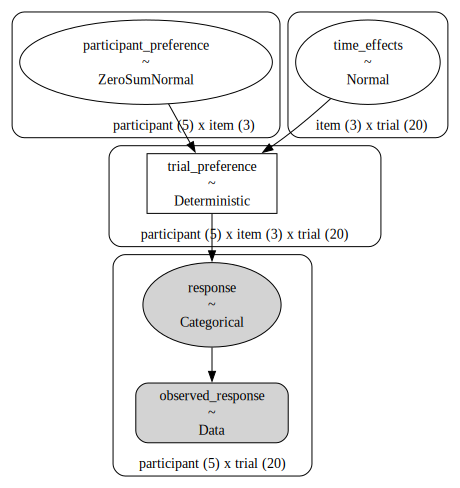

In [6]:
dmodel.to_graphviz()

To convince ourselves the models are equivalent we print the logp of each variable evaluated at the initial_point.

In [7]:
print(model.point_logps())
print(dmodel.point_logps())

{'participant_preference': np.float64(-9.19), 'time_effects': np.float64(-55.14), 'response': np.float64(-109.86)}
{'participant_preference': np.float64(-9.19), 'time_effects': np.float64(-55.14), 'response': np.float64(-109.86)}


### A brief look under the hood

The :mod:`pymc.dims` module functionality is built on top of an also experimental :mod:`pytensor.xtensor` module in PyTensor, which is the :lib:`xarray` analogous to the :mod:`pytensor.tensor` module you may be familiar with (see :doc:`pymc_and_pytensor`). Whereas regular distributions and math operations return :class:`pytensor.tensor.TensorVariable` objects, the :mod:`pymc.dims` module returns :class:`pytensor.xtensor.XTensorVariable` objects. These are very similar to TensorVariable, but they have a `dims` attribute that contains the names of the dimensions of the variable, and which modifies the behavior of operations on them.

We create a regular Normal random variable with 3 entries, and perform an outer addition on them using Numpy syntax.

In [8]:
regular_normal = pm.Normal.dist(mu=pm.math.as_tensor([0, 1, 2]), sigma=1, shape=(3,))
regular_normal.type

TensorType(float64, shape=(3,))

In [9]:
type(regular_normal)

pytensor.tensor.variable.TensorVariable

In [10]:
outer_addition = regular_normal[:, None] + regular_normal[None, :]
outer_addition.type

TensorType(float64, shape=(3, 3))

In [11]:
pm.draw(outer_addition, random_seed=rng)

array([[0.61284312, 1.68384684, 1.72225487],
       [1.68384684, 2.75485056, 2.79325859],
       [1.72225487, 2.79325859, 2.83166662]])

The same operation with a dimmed Normal variable, requires the use of `rename` so that the dimensions broadcast orthogonally.

In [12]:
dims_normal = pmd.Normal.dist(mu=pmd.math.as_xtensor([0, 1, 2], dims=("a",)), sigma=1)
dims_normal.type

XTensorType(float64, shape=(3,), dims=('a',))

In [13]:
type(dims_normal)

pytensor.xtensor.type.XTensorVariable

In [14]:
outer_addition = dims_normal + dims_normal.rename({"a": "b"})
outer_addition.type

XTensorType(float64, shape=(3, 3), dims=('a', 'b'))

In [15]:
pm.draw(outer_addition, random_seed=rng)

array([[ 3.76355516,  0.31059132,  6.5420105 ],
       [ 0.31059132, -3.14237253,  3.08904666],
       [ 6.5420105 ,  3.08904666,  9.32046584]])

### Redundant (or implicit) dims

When defining deterministic operations or creating variables whose dimension are all implied by the parameters, there's no need to specify the `dims` argument, as PyMC will automatically know them.

Despite this, we anticipate users will still want to do it. They can work as a sanity check that the dimensions of the variables are what on expects them to be, or simply as type hints for someone reading the model.

PyMC allows specifying dimensions in these cases. To reduce confusion, the output will always be transposed to be aligned with the user-specified dims.

In [16]:
with pm.Model(coords={"a": range(2), "b": range(5)}) as example:
    x = pmd.Normal("x", dims=("a", "b"))
    det_implicit_dims = pmd.Deterministic("det1", x + 1)
    det_explicit_dims = pmd.Deterministic("det2", x + 1, dims=("a", "b"))
    det_transposed_dims = pmd.Deterministic("y", x + 1, dims=("b", "a"))

print(f"{det_implicit_dims.dims=}")
print(f"{det_explicit_dims.dims=}")
print(f"{det_transposed_dims.dims=}")

det_implicit_dims.dims=('a', 'b')
det_explicit_dims.dims=('a', 'b')
det_transposed_dims.dims=('b', 'a')


This happens with `Deterministic`, `Potential` and every distribution in the `dims` module.
Everytime you specify dims you will get back a variable with the same order.

Furthermore, (and unlike regular PyMC objects) it is now valid to use ellipsis in the `dims` argument, which like in xarray transpose means "all the other dimensions" should stay in the same order.

In [17]:
with pm.Model(coords={"a": range(2), "b": range(5)}) as example:
    x = pmd.Normal("x", dims=("a", "b"))
    det_ellipsis1 = pmd.Deterministic("det1", x + 1, dims=(...,))
    det_ellipsis2 = pmd.Deterministic("det2", x + 1, dims=(..., "a"))
    det_ellipsis3 = pmd.Deterministic("det3", x + 1, dims=("b", ...))

print(f"{det_ellipsis1.dims=}")
print(f"{det_ellipsis2.dims=}")
print(f"{det_ellipsis3.dims=}")

det_ellipsis1.dims=('a', 'b')
det_ellipsis2.dims=('b', 'a')
det_ellipsis3.dims=('b', 'a')


### What functionality is supported?

The documentation is still a work in progress, and there is no complete list of distributions and operations that are supported just yet. 

#### Model constructors
The following PyMC model constructors are available in the `dims` module.

  * :func:`~pymc.dims.Data`
  * :func:`~pymc.dims.Deterministic`
  * :func:`~pymc.dims.Potential`

They all return :class:`pytensor.xtensor.type.XTensorVariable` objects, and either infer `dims` from the input or require the user to specify them explicitly. If they can be inferred, it is possible to transpose and use ellipsis in the `dims` argument, as described above.

#### Distributions
We want to offer all the existing distributions and parametrizations under the :mod:`pymc.dims` module, with the following expected API differences:
 * all vector arguments (and observed values) must have known dims. An error is raised otherwise.
 * distributions with non-scalar inputs will require a `core_dims` argument.
   * The meaning of the `core_dims` argument will be denoted in the docstrings of each distribution. For example, for the MvNormal, the `core_dims` are the two dimensions of the covariance matrix, one (and only one) of which must also be present in the mean parameter. The shared `core_dim` is the one that persists in the output. Sometimes the order of `core_dims` will be important!
 * dims accept ellipsis, and variables are transposed to match the user-specified `dims` argument.
 * shape and size cannot be provided.
 * the :met:`pymc.distributions.core.DimDistribution.dist` method accepts a `dims_length` argument, of the form `{dim_name: dim_length}`.
 * only transforms defined in :mod:`pymc.dims.transforms` can be used with distributions from the module.

#### Operations on variables

Calling a PyMC distribution from the :mod:`pymc.dims` module returns an :class:`pytensor.xtensor.type.XTensorVariable`.

The expectation is that every :class:`xarray.DataArray` method in xarray should have an equivalent version for XTensorVariables. So if you can do `x.diff(dim="a")` in xarray, you should be able to do `x.diff(dim="a")` with XTensorVariables as well.

In addition, many numerical operations are available in the :mod:`pymc.dims.math` module, which provides a superset of `ufuncs` functions found in xarray (like `exp`). It also includes submodules such as `linalg` that provide counterpart to libraries like :lib:`xarray_einstats` (such as `linalg.solve`).

Finally, functions that are available at the module level in xarray (like `concat`) are also available in the :mod:`pymc.dims` namespace.

To facilitate adoption of these functions and methods, we try to follow the same API used by the xarray and related packages. However, some methods or keyword arguments won't be supported explicitly (like `.isel`, more on that at the end), in which case an informative error or warning will be raised. 

If you find an API difference or some missing functionality, and no reason is provided, please [open an issue](https://github.com/pymc-devs/pymc/issues) to let us know (after checking nobody has done it already).

In the meantime, the next section provides some hints on how to make use of pre-existing functionality in PyMC/PyTensor.

### Combining dims module with the old API

Because the `dims` module is more recent in does not offer all the functionality of the old API.

You can always combine the two APIs by converting the variables explicitly. To obtain a regular non-dimmed variable from a dimmed variable, you can use :attr:`pytensor.xtensor.type.XTensorVariable.values` (like in xarray) or the more verbose :func:`pymc.dims.as_xtensor`.

Otherwise, if you try to pass an XTensorVariable to a function or distribution that does not support it, you will usually see an error like this:

In [18]:
mu = pmd.math.as_xtensor([0, 1, 2], dims=("a",))
try:
    pm.Normal.dist(mu=mu)
except TypeError as e:
    print(f"{e.__class__.__name__}: {e}")

TypeError: To avoid subtle bugs, PyTensor forbids automatic conversion of XTensorVariable to TensorVariable.
You can convert explicitly using `x.values` or pass `allow_xtensor_conversion=True`.


In [19]:
pm.Normal.dist(mu=x.values).type

TensorType(float64, shape=(None, None))

The order of the dimensions follows that specified in the :attr:`pytensor.xtensor.type.XTensorVariable.dims` property. To be sure this matches the expectation you can use a :met:`pytensor.xtensor.type.XTensorVariable.transpose` operation to reorder the dimensions before converting to a regular variable.

Conversely, if you try to pass a regular variable to a function or distribution that expects an XTensorVariable, you will see an error like this:

In [20]:
mu = pm.math.as_tensor([0, 1, 2], name="mu_x")
try:
    x = pmd.Normal.dist(mu=mu)
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

ValueError: Variable mu_x{[0 1 2]} must have dims associated with it.
To avoid subtle bugs, PyMC does not make any assumptions about the dims of parameters.
Use `as_xtensor` with the `dims` keyword argument to specify the dims explicitly.


Which you can avoid by explicitly converting the variable to a dimmed variable:

In [21]:
pmd.Normal.dist(mu=pmd.as_xtensor(mu, dims=("a",))).type

XTensorType(float64, shape=(3,), dims=('a',))

#### Example

To put this to practice, let us write a model that uses the :class:`~pymc.LKJCholeskyCov` distribution, which at the time of writing is not yet available in the :mod:`pymc.dims` module.

In [22]:
with pm.Model(coords={"core1": range(3), "core2": range(3), "batch": range(5)}) as mixed_api_model:
    chol, _, _ = pm.LKJCholeskyCov(
        "chol",
        eta=1,
        n=3,
        sd_dist=pm.Exponential.dist(1),
    )
    chol_xr = pmd.as_xtensor(chol, dims=("core1", "core2"))

    mu = pmd.Normal("mu", dims=("batch", "core1"))
    y = pmd.MvNormal(
        "y",
        mu,
        chol=chol_xr,
        core_dims=("core1", "core2"),
    )

print(f"{chol_xr.dims=}")
print(f"{mu.dims=}")
print(f"{y.dims=}")

chol_xr.dims=('core1', 'core2')
mu.dims=('batch', 'core1')
y.dims=('batch', 'core1')


Note that we had to pass a "regular" Exponential distribution to the :class:`~pymc.LKJCholeskyCov` constructor. In general all distribution "factories" which are parametrized by unnamed distributions created with the :met:`pymc.distributions.distribution.Distribution.dist` method, won't work with variables created with the :mod:`pymc.dims` module.

Overtime we hope to implement such functionality directly in the :mod:`pymc.dims` module, but for now you have to be aware of this limitation.

## Case study: a splines model comes ashore

### A model begging for vectorization

The model below was presented by a user in a [bug report](). There may have been other reasons for approaching the model in this way, and it may have deviated from the user application for the purposes of providing a reproducible example for the bug report.

With the disclaimer out of the way, we can say that the model is written in a way that is highly suboptimal. Specifically it misses (or actively breaks) many opportunities for vectorization. Seasoned Python programmers will know that python loops are SLOW, and that tools like numpy provide a way to escape from this handicap.

PyMC code is not exactly numpy, for starters it uses a lazy symbolic computation library (PyTensor) that generates compiled code on demand. But it very much likes to be given numpy-like code. To begin with these graphs are much smaller and therefore easier to reason about (in fact the original bug could only be triggered for graphs with more than 500 nodes). Secondly, numpy-like graphs naturally translate to vectorized CPU and GPU code, which you want at the end of the day.

In [23]:
# Simulated data of some spline
N = 500
x_np = np.linspace(0, 10, N)
y_obs_np = np.piecewise(
    x_np,
    [x_np <= 3, (x_np > 3) & (x_np <= 7), x_np > 7],
    [lambda x: 0.5 * x, lambda x: 1.5 + 0.2 * (x - 3), lambda x: 2.3 - 0.1 * (x - 7)],
)
y_obs_np += rng.normal(0, 0.2, size=N)  # Add noise

# Artificial groups
groups = [0, 1, 2]
group_idx_np = np.random.choice(groups, size=N)

n_knots = 50
knots_np = np.linspace(0, 10, num=n_knots)

In [24]:
with pm.Model() as non_vectorized_splines_model:
    sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=1)

    # Create likelihood per group
    for gr in groups:
        idx = group_idx_np == gr

        beta0 = pm.HalfNormal(f"beta0_{gr}", sigma=sigma_beta0)
        z = pm.Normal(f"z_{gr}", mu=0, sigma=2, shape=n_knots)

        delta_factors = pm.math.softmax(z)
        slope_factors = 1 - pm.math.cumsum(delta_factors[:-1])
        spline_slopes = pm.math.stack(
            [beta0] + [beta0 * slope_factors[i] for i in range(n_knots - 1)]
        )
        beta = pm.Deterministic(
            f"beta_{gr}",
            pm.math.concatenate(([beta0], pm.math.diff(spline_slopes))),
        )

        hinge_terms = [pm.math.maximum(0, x_np[idx] - knot) for knot in knots_np]
        X = pm.math.stack([hinge_terms[i] for i in range(n_knots)], axis=1)

        mu = pm.math.dot(X, beta)

        pm.Normal(f"y_{gr}", mu=mu, sigma=sigma, observed=y_obs_np[idx])

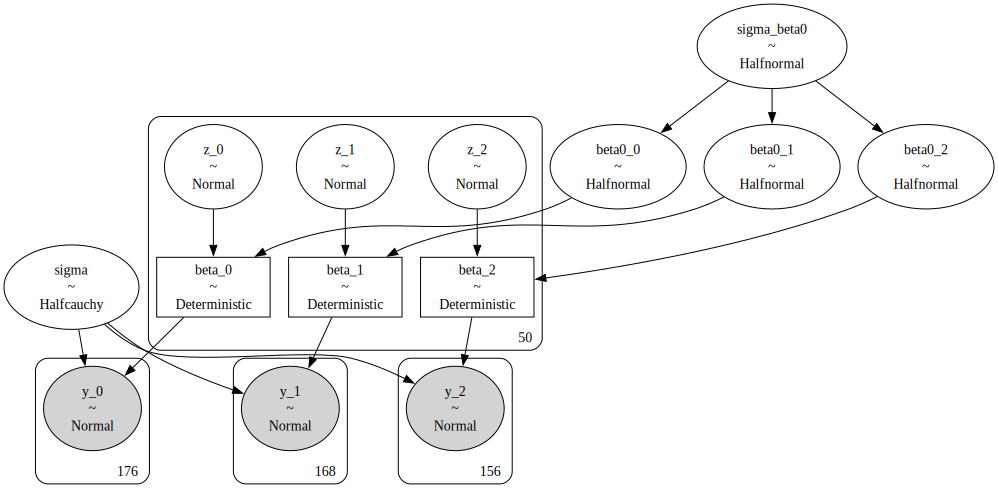

In [25]:
non_vectorized_splines_model.to_graphviz()

### Old style vectorization

With some work we can rewrite the model to use vectorized operations.

We'll introduce `coords` and :func:`~pymc.Data` to make the model more self-contained.

In [26]:
coords = {
    "group": range(3),
    "knots": range(n_knots),
    "obs": range(N),
}
with pm.Model(coords=coords) as vectorized_splines_model:
    x = pm.Data("x", x_np, dims="obs")
    y_obs = pm.Data("y_obs", y_obs_np, dims="obs")

    knots = pm.Data("knots", knots_np, dims="knot")

    sigma = pm.HalfCauchy("sigma", beta=1)
    sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=10)
    beta0 = pm.HalfNormal("beta_0", sigma=sigma_beta0, dims="group")
    z = pm.Normal("z", dims=("group", "knot"))

    delta_factors = pm.math.softmax(z, axis=-1)  # (groups, knot)
    slope_factors = 1 - pm.math.cumsum(delta_factors[:, :-1], axis=-1)  # (groups, knot-1)
    spline_slopes = pm.math.concatenate(
        [beta0[:, None], beta0[:, None] * slope_factors], axis=-1
    )  # (groups, knot-1)
    beta = pm.math.concatenate(
        [beta0[:, None], pm.math.diff(spline_slopes, axis=-1)], axis=-1
    )  # (groups, knot)

    beta = pm.Deterministic("beta", beta, dims=("group", "knot"))

    X = pm.math.maximum(0, x[:, None] - knots[None, :])  # (n, knot)
    mu = (X * beta[group_idx_np]).sum(-1)  # ((n, knots) * (n, knots)).sum(-1) = (n,)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs, dims="obs")

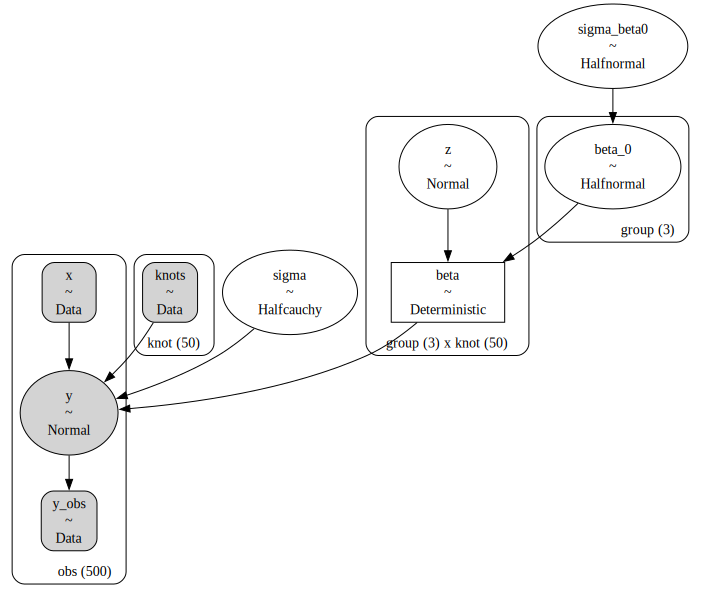

In [27]:
vectorized_splines_model.to_graphviz()

The graphviz does not show the whole complexity of the models. The biggest problem lied in the multiple list comprehensions used in the origin model. Every iteration extends the computational graph (basically unrolling the python loop), which becomes unfeasible for PyMC to handle.

The use of 3 likelihood and sets of priors is otherwise fine and can make more sense in some cases.

In [28]:
from pytensor.graph import FunctionGraph

non_vectorized_splines_model_graph = FunctionGraph(
    outputs=non_vectorized_splines_model.observed_RVs, clone=False
)
vectorized_model_nodes = len(
    FunctionGraph(outputs=vectorized_splines_model.basic_RVs, clone=False).apply_nodes
)
print(f"Non-vectorized model has {len(non_vectorized_splines_model_graph.apply_nodes)} nodes")
print(f"Vectorized model has {vectorized_model_nodes} nodes")

Non-vectorized model has 806 nodes
Vectorized model has 38 nodes


### Vectorization with dims

It is however not trivial to write (or translate into) vectorized code like this. It takes some time to grok the patterns and there are many pain-points. We reckon that the conversion between the first and second model took at least one hour, including debugging and testing that the models were indeed equivalent.

We believe that the :mod:`pymc.dims` module will facilitate writing efficient vectorized code. So let's try and do that.

In [29]:
with pm.Model(coords=coords) as dims_splines_model:
    x = pmd.Data("x", x_np, dims="obs")
    y_obs = pmd.Data("y_obs", y_obs_np, dims="obs")
    knots = pmd.Data("knots", knots_np, dims=("knot",))
    group_idx = pmd.math.as_xtensor(group_idx_np, dims=("obs",))

    sigma = pmd.HalfCauchy("sigma", beta=1)
    sigma_beta0 = pmd.HalfNormal("sigma_beta0", sigma=10)
    beta0 = pmd.HalfNormal("beta_0", sigma=sigma_beta0, dims=("group",))
    z = pmd.Normal("z", dims=("group", "knot"))

    delta_factors = pmd.math.softmax(z, dim="knot")
    slope_factors = 1 - delta_factors.isel(knot=slice(None, -1)).cumsum("knot")
    spline_slopes = pmd.concat([beta0, beta0 * slope_factors], dim="knot")
    beta = pm.Deterministic("beta", pmd.concat([beta0, spline_slopes.diff("knot")], dim="knot"))

    X = pmd.math.maximum(0, x - knots)
    mu = (X * beta.isel(group=group_idx)).sum("knot")
    y = pmd.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

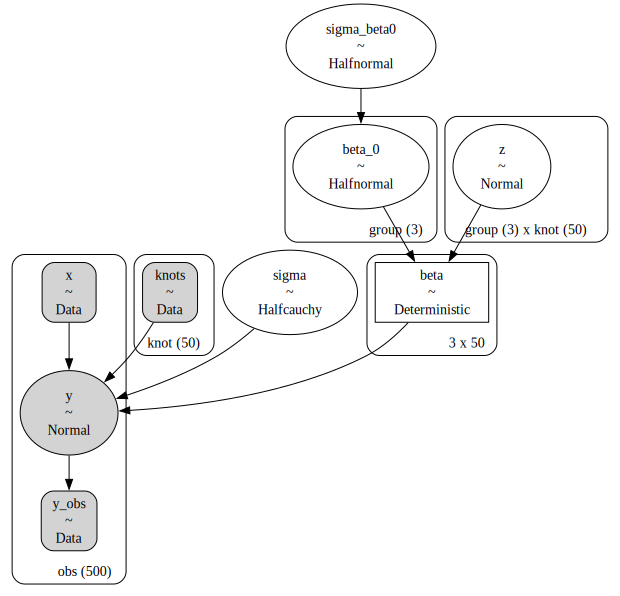

In [30]:
dims_splines_model.to_graphviz()

In [31]:
# Comment out if you want to wait a long while for the results
# non_vectorized_splines_model.point_logps()

In [32]:
vectorized_splines_model.point_logps()

{'sigma': np.float64(-1.14),
 'sigma_beta0': np.float64(-0.73),
 'beta_0': np.float64(-2.18),
 'z': np.float64(-137.84),
 'y': np.float64(-319962.47)}

In [33]:
dims_splines_model.point_logps()

{'sigma': np.float64(-1.14),
 'sigma_beta0': np.float64(-0.73),
 'beta_0': np.float64(-2.18),
 'z': np.float64(-137.84),
 'y': np.float64(-319962.47)}

## What about coordinates?

The new xtensor variable and operations do not propagate information about coordinates, which means you cannot perform coordinate-related operations like you can in xarray.
This includes things like `sel`, `loc`, `drop`.

While it is perhaps disappointing for someone used to xarray, it is a necessary trade-off to allow PyMC to evaluate the model in a performant way. Just like before, PyMC uses PyTensor under the hood, which at the end of the day compiles functions down into the C (or numba or JAX) backends. None of these backends support dims or coordinates. To be able to keep using these backends, PyTensor rewrites the xtensor operations into equivalent tensor operations, which are pretty much abstract numpy code. This is relative easy to do because it's mostly about aligning dimensions for broadcasting or indexing correctly.

Rewriting coordinate-related operations into numpy-like code is a different matter. Many such operations don't have straightforward equivalency, they are more like querying or joining a database than performing array operations.

PyMC models will keep supporting the `coords` argument as a way to specify dimensions of model variables. But for modelling purposes, only the dimension names and their lengths play a role.

### One final note of caution on coordinates

When you provide coords to a PyMC model, they will be attached to any functions that returns xarray or InferenceData objects.

There is one potential issue with this. Like in xarray it is valid to have multiple arrays with the same dims but different shapes. Some operations, like indexing or concatenating, act on this premise. This is also possible with PyMC models, and in fact we had such a case in the last example when we indexed the spline variable.

After sampling, PyMC will try to reattach the coordinates to any computed variables (i.e., distributions, data or deterministics), but these might not have the right shape, or they might not be correctly aligned. 

We illustrate this with next model, where we have two variables with the `a` dim but different shapes, and only one matches the shape of the coordinates specified in the model. When PyMC tries to convert the results of sampling to InferenceData, it will issue a warning and refuse to propagate the original coordinates.

In [34]:
with pm.Model(coords={"a": [-1, 0, 1]}) as m:
    x = pmd.Normal("x", dims=("a",))
    y = pmd.Deterministic("y", x.isel(a=slice(1, None)))
    assert y.dims == ("a",)

    idata = pm.sample_prior_predictive()
idata.prior["y"].coords

Sampling: [x]
/home/ricardo/Documents/pymc/pymc/backends/arviz.py:70: UserWarning: Incompatible coordinate length of 3 found for dimension a of variable y.
The originate coordinates for this dim will not be included in the returned dataset for any of the variables. Instead they will default to `np.arange(var_length)` and the shorter variables will be right-padded with nan.
To make this warning into an error set `pymc.backends.arviz.RAISE_ON_INCOMPATIBLE_COORD_LENGTHS` to `True`
  warnings.warn(


Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * a        (a) int64 24B 0 1 2

A user who wishes to retain coondinates for further analysis will have to manually specify them after sampling or to rename the intermediate dimensions to something else that has compatible coordinates.

In [35]:
with pm.Model(coords={"a": [-3, -2, -1], "a*": [-2, -1]}) as m:
    x = pmd.Normal("x", dims=("a",))
    y = pmd.Deterministic("y", x.isel(a=slice(1, None)).rename({"a": "a*"}))
    assert y.dims == ("a*",)
    # You can rename back to the original name if you need it for further operations
    y = y.rename({"a*": "a"})

    idata = pm.sample_prior_predictive(draws=1)
idata.prior["y"].coords

Sampling: [x]


Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8B 0
  * a*       (a*) int64 16B -2 -1

Note that when doing advanced indexing the name of the indexed dimension can be controlled by the name of the indexing xtensor

In [36]:
x.isel(a=pmd.math.as_xtensor([0, 1, 2], dims=("a*",))).dims

('a*',)

Silent bugs can still happen if the shapes are compatible with the wrong coords as in the example below

In [37]:
with pm.Model(coords={"a": [1, 2, 3]}):
    x = pmd.Normal("x", dims=("a",))
    pmd.Deterministic("x_reversed", x[::-1])
    idata = pm.sample_prior_predictive(draws=1)
idata.prior["x_reversed"].coords

Sampling: [x]


Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8B 0
  * a        (a) int64 24B 1 2 3

Whereas xarray would flip the coordinates

In [38]:
idata.prior["x"].isel(a=slice(None, None, -1)).coords

Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8B 0
  * a        (a) int64 24B 3 2 1

This is a symptom of PyMC inability to reason about coords symbolically. Is not a new problem with the :mod:`pymc.dims` module, but it is made more likely because the functions from the :mod:`pymc.dims` module require and propagate dimension names everywhere. We are still working on how to work around the problem of incompatible coordinates.

We remind users that :func:`~pymc.Deterministic` are never required in a model, they are just a way to request that some intermediate operations be included in the returned results. If you use them, pay extra attention to whether the model level coordinates are appropriate for the variable in the :func:`~pymc.Deterministic`.